#### Code to train models

In [260]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [261]:
cd ../src

/home/theo/kaggle/siim_covid/src


## Imports

In [262]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from tqdm.notebook import tqdm

In [263]:
from params import *

In [264]:
from data.preparation import prepare_new_data, prepare_extra_data

from data.dataset import CovidDataset
from data.transforms import get_transfos

# from model_zoo.models import define_model

from utils.plot import plot_sample
from utils.logger import prepare_log_folder, save_config, create_logger, update_overall_logs

## Data

### Load

In [265]:
df_study = pd.read_csv(DATA_PATH + 'train_study_level.csv')
df_image = pd.read_csv(DATA_PATH + 'train_image_level.csv')

In [266]:
df_study['study_id'] = df_study['id'].apply(lambda x: x.split('_')[0])
df_study = df_study.rename(columns={c : c.split(' ')[0].lower() for c in df_study.columns})
df_study.drop('id', axis=1, inplace=True)

In [267]:
df_image = df_image.rename(columns={'id': "image_id", "StudyInstanceUID": "study_id"})
df_image['image_id'] = df_image['image_id'].apply(lambda x: x.split('_')[0])
df_image = df_image.merge(df_study, on="study_id", how="left")

In [268]:
meta = pd.read_csv(DATA_PATH + "meta.csv")
df_image = df_image.merge(meta, how="left", on="image_id")

In [269]:
df_image['label'][0]

'opacity 1 789.28836 582.43035 1815.94498 2499.73327 opacity 1 2245.91208 591.20528 3340.5737 2352.75472'

In [270]:
import json
s = df_image['boxes'][0]
json_acceptable_string = s.replace("'", "\"")
d = json.loads(json_acceptable_string)
# d = {u'muffin': u'lolz', u'foo': u'kitty'}

In [271]:
d[0]

{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}

In [272]:
df_image

,image_id,boxes,label,study_id,negative,typical,indeterminate,atypical,dim0,dim1,split
0,000a312787f2,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,0,1,0,0,3488,4256,train
1,000c3a3f293f,NaN,none 1 0 0 1 1,ff0879eb20ed,1,0,0,0,2320,2832,train
2,0012ff7358bc,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,0,1,0,0,2544,3056,train
3,001398f4ff4f,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,0,0,0,1,3520,4280,train
4,001bd15d1891,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,0,1,0,0,2800,3408,train
...,...,...,...,...,...,...,...,...,...,...,...
6329,ffcc6edd9445,NaN,none 1 0 0 1 1,7e6c68462e06,1,0,0,0,4240,3480,train
6330,ffd91a2c4ca0,NaN,none 1 0 0 1 1,8332bdaddb6e,1,0,0,0,2800,3408,train
6331,ffd9b6cf2961,"[{'x': 2197.38566, 'y': 841.07361, 'width': 31...",opacity 1 2197.38566 841.07361 2513.80265 1292...,7eed9af03814,0,1,0,0,2388,3050,train
6332,ffdc682f7680,"[{'x': 2729.27083, 'y': 332.26044, 'width': 14...",opacity 1 2729.27083 332.26044 4225.52099 2936...,a0cb0b96fb3d,0,1,0,0,3488,4256,train


In [273]:
def treat_boxes(boxes_string):
    try:
        boxes_string = boxes_string.replace("'", "\"")
    except AttributeError:
        return []

    boxes_dic = json.loads(boxes_string)
    
    boxes = []
    for b in boxes_dic:
        boxes.append([b['x'], b['y'], b['width'], b['height']])
    return boxes

df_image['boxes'] = df_image['boxes'].apply(treat_boxes)

In [274]:
df_image.head()

,image_id,boxes,label,study_id,negative,typical,indeterminate,atypical,dim0,dim1,split
0,000a312787f2,"[[789.28836, 582.43035, 1026.65662, 1917.30292...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,0,1,0,0,3488,4256,train
1,000c3a3f293f,[],none 1 0 0 1 1,ff0879eb20ed,1,0,0,0,2320,2832,train
2,0012ff7358bc,"[[677.42216, 197.97662, 867.79767, 999.78214],...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,0,1,0,0,2544,3056,train
3,001398f4ff4f,"[[2729, 2181.33331, 948.00012, 604]]",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,0,0,0,1,3520,4280,train
4,001bd15d1891,"[[623.23328, 1050, 714, 1106], [2578.56661, 99...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,0,1,0,0,2800,3408,train


### Dataset

In [284]:
dataset = CovidDataset(df_image, TRAIN_IMG_PATH)

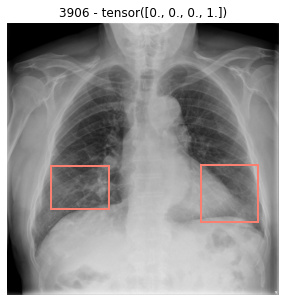

In [292]:
for i in np.random.choice(len(dataset), 1):
    img, y, boxes = dataset[i]
    
    plot_sample(img, boxes)
    plt.title(f'{i} - {y}')